# Beating the Market with AI

### Initial Project Setup

In [83]:
# Initial library and module imports
import numpy as np
import talib as ta
import pandas as pd
import hvplot.pandas
from pathlib import Path
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

# Example imports for models and algorithms

# from sklearn import svm
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report

# Disable false positive error message
pd.options.mode.chained_assignment = None

In [84]:
# Initial file uploads for Google Colab
# from google.colab import files
# uploaded = files.upload()

### Data Import & Preparation

In [85]:
# Read csv into dataframe - Colab

# Apple dataframe
# aapl_df = pd.read_csv(
#     Path("./AAPL.csv"),
#     index_col="Date",
#     parse_dates=True,
#     infer_datetime_format=True
# )

# Microsoft dataframe
# msft_df = pd.read_csv(
#     Path("./MSFT.csv"),
#     index_col="Date",
#     parse_dates=True,
#     infer_datetime_format=True
# )

# Read csvs into dataframe - Non-Colab

# Apple dataframe
aapl_df = pd.read_csv(
    Path("./data/AAPL.csv"),
    index_col="Date",
    parse_dates=True,
    infer_datetime_format=True
)

# Microsoft dataframe
msft_df = pd.read_csv(
    Path("./data/MSFT.csv"),
    index_col="Date",
    parse_dates=True,
    infer_datetime_format=True
)

In [101]:
# Verify dataframe
aapl_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100039,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094820,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087861,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090035,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092646,73449600


In [102]:
# Verify dataframe
msft_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


### Stock Trading Algorithm

In [103]:
# Create a new dataframe to hold the closing prices and future indicator and signal values. Starting values set to ~10 years of data

# Apple
aapl_technical_df = aapl_df.loc["2012-01-01":, ["Close"]]

# Microsoft
msft_technical_df = msft_df.loc["2012-01-01":, ["Close"]]

In [104]:
# Add daily return values to the dataframes and drop NaN values

# Apple
aapl_technical_df["Actual Returns"] = aapl_technical_df["Close"].pct_change()

aapl_technical_df = aapl_technical_df.dropna()

# Microsoft
msft_technical_df["Actual Returns"] = msft_technical_df["Close"].pct_change()

msft_technical_df = msft_technical_df.dropna()

In [105]:
# Add EMA to the dataframe for use in algorithm and drop NaN values created for EMA indicators

# Apple
aapl_technical_df["7 Day EMA"] = ta.EMA(aapl_technical_df["Close"], timeperiod = 7)

aapl_technical_df["14 Day EMA"] = ta.EMA(aapl_technical_df["Close"], timeperiod = 14)

aapl_technical_df["28 Day EMA"] = ta.EMA(aapl_technical_df["Close"], timeperiod = 28)

aapl_technical_df = aapl_technical_df.dropna()

# Microsoft
msft_technical_df["7 Day EMA"] = ta.EMA(msft_technical_df["Close"], timeperiod = 7)

msft_technical_df["14 Day EMA"] = ta.EMA(msft_technical_df["Close"], timeperiod = 14)

msft_technical_df["28 Day EMA"] = ta.EMA(msft_technical_df["Close"], timeperiod = 28)

msft_technical_df = msft_technical_df.dropna()

In [106]:
# Add additional MACD and RSI indicators for usage with models

# Apple
# Create MACD and RSI indicators
macd, macdsignal, macdhist = ta.MACD(aapl_technical_df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
real = ta.RSI(aapl_technical_df["Close"], timeperiod=14)

# Create a dataframe from the indicator data
df = pd.concat({
    "MACD":macd,
    "MACD Signal":macdsignal,
    "MACD Hist":macdhist,
    "RSI":real
}, axis=1)

# Join the original dataframe and the indicators dataframe
aapl_technical_df = aapl_technical_df.join(df)

# Microsoft
# Create MACD and RSI indicators
macd, macdsignal, macdhist = ta.MACD(msft_technical_df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
real = ta.RSI(msft_technical_df["Close"], timeperiod=14)

# Create a dataframe from the indicator data
df = pd.concat({
    "MACD":macd,
    "MACD Signal":macdsignal,
    "MACD Hist":macdhist,
    "RSI":real
}, axis=1)

# Join the original dataframe and the indicators dataframe
msft_technical_df = msft_technical_df.join(df)

In [107]:
# Create signals column to store buy and sell signals

# Apple
aapl_technical_df["Signals"] = 0.0

# Microsoft
msft_technical_df["Signals"] = 0.0

In [118]:
# Create signals algorithm to identify when 7 Day EMA is above the 14 & 28 day to generate a buy signal and when 7 Day EMA is below 14 & 28 day to generate a sell signal

# Apple
aapl_technical_df.loc[
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["14 Day EMA"])
    &
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["28 Day EMA"]), 
    "Signals"
] = 1

aapl_technical_df.loc[
    (aapl_technical_df["7 Day EMA"] < aapl_technical_df["14 Day EMA"])
    &
    (aapl_technical_df["7 Day EMA"] > aapl_technical_df["28 Day EMA"]), 
    "Signals"
] = -1

# Microsoft
msft_technical_df.loc[
    (msft_technical_df["7 Day EMA"] > msft_technical_df["14 Day EMA"]) 
    & 
    (msft_technical_df["7 Day EMA"] > msft_technical_df["28 Day EMA"]), 
    "Signals"
] = 1

msft_technical_df.loc[
    (msft_technical_df["7 Day EMA"] < msft_technical_df["14 Day EMA"]) 
    & 
    (msft_technical_df["7 Day EMA"] > msft_technical_df["28 Day EMA"]), 
    "Signals"
] = -1

In [119]:
# Create strategy returns column

# Apple
aapl_technical_df["Strategy Returns"] = aapl_technical_df["Actual Returns"] * aapl_technical_df["Signals"].shift()

# Microsoft
msft_technical_df["Strategy Returns"] = msft_technical_df["Actual Returns"] * msft_technical_df["Signals"].shift()

<AxesSubplot:xlabel='Date'>

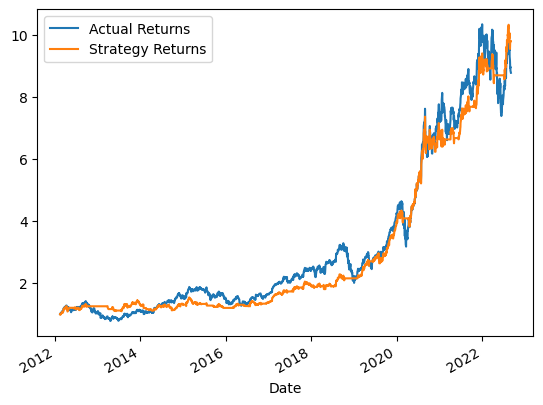

In [120]:
# Review cumulative return plot - Apple
(1 + aapl_technical_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

<AxesSubplot:xlabel='Date'>

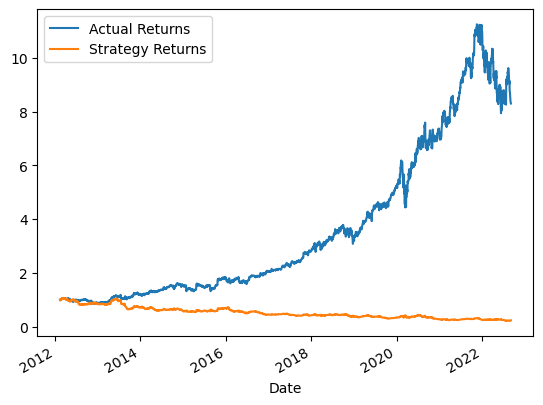

In [121]:
# Review cumulative return plot - Microsoft
(1 + msft_technical_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

In [122]:
# Review resulting dataframe - Apple
aapl_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,MACD,MACD Signal,MACD Hist,RSI,Signals,Strategy Returns
Date,,,,,,,,,,,
2012-02-13,17.950001,0.018605,17.244628,16.727974,15.854579,NaN,NaN,NaN,NaN,1.0,NaN
2012-02-14,18.195000,0.013649,17.482221,16.923577,16.015987,NaN,NaN,NaN,NaN,1.0,0.013649
2012-02-15,17.773930,-0.023142,17.555149,17.036958,16.137225,NaN,NaN,NaN,NaN,1.0,-0.023142
2012-02-16,17.936071,0.009122,17.650379,17.156839,16.261283,NaN,NaN,NaN,NaN,1.0,0.009122
2012-02-17,17.932858,-0.000179,17.720999,17.260309,16.376564,NaN,NaN,NaN,NaN,1.0,-0.000179
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,158.910004,-0.015305,164.483905,165.845999,163.460681,1.895740,3.953608,-2.057868,41.642421,-1.0,0.015305
2022-08-31,157.220001,-0.010635,162.667929,164.695866,163.030289,1.070936,3.377073,-2.306137,39.315121,0.0,0.010635
2022-09-01,157.960007,0.004707,161.490949,163.797751,162.680615,0.471550,2.795969,-2.324419,40.873353,0.0,0.000000


In [123]:
# Review resulting dataframe - Microsoft
msft_technical_df

,Close,Actual Returns,7 Day EMA,14 Day EMA,28 Day EMA,MACD,MACD Signal,MACD Hist,RSI,Signals,Strategy Returns
Date,,,,,,,,,,,
2012-02-13,30.580000,0.002623,30.414340,30.013269,29.167857,NaN,NaN,NaN,NaN,1.0,NaN
2012-02-14,30.250000,-0.010791,30.373255,30.044833,29.242488,NaN,NaN,NaN,NaN,1.0,-0.010791
2012-02-15,30.049999,-0.006612,30.292441,30.045522,29.298178,NaN,NaN,NaN,NaN,1.0,-0.006612
2012-02-16,31.290001,0.041265,30.541831,30.211452,29.435545,NaN,NaN,NaN,NaN,1.0,0.041265
2012-02-17,31.250000,-0.001278,30.718873,30.349925,29.560680,NaN,NaN,NaN,NaN,1.0,-0.001278
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30,262.970001,-0.008521,271.699000,275.997926,275.842781,-0.744901,2.793705,-3.538606,36.633382,-1.0,0.008521
2022-08-31,261.470001,-0.005704,269.141751,274.060869,274.851555,-1.795519,1.875860,-3.671379,35.536546,-1.0,0.005704
2022-09-01,260.399994,-0.004092,266.956311,272.239419,273.854896,-2.683547,0.963979,-3.647526,34.737551,-1.0,0.004092


### Stock A Models - AAPL

#### Data Prep

#### Model A

#### Model B

#### Model C

### Stock B Models - MSFT

#### Data Prep

#### Model A

#### Model B

#### Model C

### Analysis & Comparison

In [100]:
# Compare models used on first stock and retested on second stock.